# Histograms on numerical datasets

Histogram graphs are a very handy way to visualize numerical data, compare different values of a specific field, and thus extract conclusions about the dataset. We are going to study the `diffprivlib`'s method of creating an histogram, and its accuracy when changing the epsilon factor.

The IBM DP library offers a differential private way to create histograms. The difference with the simple queries that we tested, is that now, __geometric truncated__ noise is added in order to satisfy DP.

## The identity of the dataset: Employee salaries

The dataset contains sensitive data regarding employee's salaries in the state of Baltimore, while stating other facts about the members of the dataset. 

The columns contained are: 
 - __Name__
 - __Job Title__
 - __ID__
 - __Job description__
 - __Hire date__
 - __Annual earnings__
 - __Gross earnings__

## Import libraries

In [1]:
import pandas as pd
import diffprivlib as dp
import numpy as np
import math
import matplotlib.pyplot as plt

## Load the dataset

In [2]:
DATASET = "./complete_salaries.csv"
df = pd.read_csv(DATASET)

Let's take a look at the dataset info to see if everything is alright.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13811 entries, 0 to 13810
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NAME       13811 non-null  object 
 1   JOBTITLE   13811 non-null  object 
 2   DEPTID     13811 non-null  object 
 3   DESCR      13811 non-null  object 
 4   HIRE_DT    13807 non-null  object 
 5   ANNUAL_RT  13811 non-null  float64
 6   Gross      13158 non-null  float64
dtypes: float64(2), object(5)
memory usage: 755.4+ KB


In [4]:
df.head()

,NAME,JOBTITLE,DEPTID,DESCR,HIRE_DT,ANNUAL_RT,Gross
0,"Aaron,Kareem D",Utilities Inst Repair I,A50550,DPW-Water & Waste Water (550),08/27/2018 12:00:00 AM,32470.0,25743.94
1,"Aaron,Patricia G",Facilities/Office Services II,A03031,OED-Employment Dev (031),10/24/1979 12:00:00 AM,60200.0,57806.13
2,"Abadir,Adam O",Council Technician,A02002,City Council (002),12/12/2016 12:00:00 AM,64823.0,64774.11
3,"Abaku,Aigbolosimuan O",Police Officer,A99094,Police Department (094),04/17/2018 12:00:00 AM,53640.0,59361.55
4,"Abbeduto,Mack",Assistant State's Attorney,A29011,States Attorneys Office (011),05/22/2017 12:00:00 AM,68562.0,61693.59


## Privacy Setup

### Target column

Throughout our tests, we are going to apply noise into 2 target columns: the __annual earnings__, and the __gross earnings__.

### Bounds definition

With our prior knowledge regarding the IBM's bounds' selection requirements, we are going to define ourselves the bounds for the DP algorithms, by guessing the possible minimum and maximum values.

In [5]:
annual_earnings_range = (0, 500000)
annual_gross_range = (0, 500000)

## Histograms

We are going to run various histograms, in order to observe the effect of applying DP to our dataset. 

A histogram is a graphical representation that organizes a group of data points into user-specified ranges, called bins. The `numpy` function will take as input the data and the pre-specified bins, and return the distribution of the points in each one of the bins.

Those bins, are chosen by default given the lowest and the highest values of the dataset. Since we are applying DP though, we already know that such information leakage is unacceptable: we must predefine the bins given what we think of the bounds, independently of our knowledge of the dataset. 

We will see further details as we move on.

### Accurate testings

We know by now that the noise inserted in the query by the DP algorithms is based on probabilistic distributions. Thus, it is clear that our testings will not be accurate if we run the query once, because it is possible that we get extreme values of noise, and as a result, extreme differences between the real histogram and the noisy one. 

In order to achieve that, we are going to define a function that takes as an argument the arguments of the hist function, runs the histogram query multiple times, and finally returns the mean value of all of those runs.

In [6]:
def accurate_histogram(input_list, bins, epsilon, bounds_range):
    # initialize a list of the upcoming result of the histogram
    result = [0] * (bins + 1)
    for i in range (1, 100):
        # compute the i-th histogram
        new_list = dp.tools.histogram(input_list, bins = bins, epsilon = epsilon, range = bounds_range)[0]
        # compute the bins to return, but only once
        if (i == 1):
            new_bins = dp.tools.histogram(input_list, bins = bins, epsilon = epsilon, range = bounds_range)[1]
        # calculate a new list, by adding the previous, and the new histogram
        result = [sum(x) for x in zip(result, new_list)]
    # finally return the mean results of the 100 histograms
    return [(math.floor(a / 100)) for a in result], new_bins

### Accuracy error

A handy way to compute the accuracy error is to find the __l1-norm__ of the vector that consists of the accuracy errors in each bins. Thus, the total error is given by:

$error = ||abs(dp - non\_dp)||_1$ ,
where dp and non-dp are the vectors of the results of the DP and non-DP queries respectively.

The final accuracy error will emerge by finding the mean value of multiple executions of the DP histogram.

In [7]:
def accuracy_error(non_dp_vector, input_list, bins, epsilon, bounds_range):
    # initialize the accuracy error
    error = 0
    # create many histograms
    for i in range (100):
        # compute the i-th histogram
        dp_vector = dp.tools.histogram(input_list, bins = bins, epsilon = epsilon, range = bounds_range)[0]
        # increase each time by the l1-norm of the accuracy error vector
        error += np.linalg.norm(abs(dp_vector - non_dp_vector), ord = 1)
    # finally return the mean results of the 100 histograms
    return error / 100

### Histogram on annual earnings

We are going to study our dataset data, by creating a histogram based on the annual earnings. Let's start with a normal hist, without differential privacy.

We are not going to let numpy define our bins for us. We want the non-DP histogram to be in the same scale as the DP one that we are going to define later, which is going to have as a maximum and minimum the bounds that we have already defined.

(array([5.453e+03, 4.202e+03, 2.314e+03, 5.150e+02, 9.200e+01, 2.900e+01,
        1.400e+01, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([ 26315.78947368,  51169.59064327,  76023.39181287, 100877.19298246,
        125730.99415205, 150584.79532164, 175438.59649123, 200292.39766082,
        225146.19883041, 250000.        , 274853.80116959, 299707.60233918,
        324561.40350877, 349415.20467836, 374269.00584795, 399122.80701754,
        423976.60818713, 448830.40935673, 473684.21052632]),
 <a list of 18 Patch objects>)

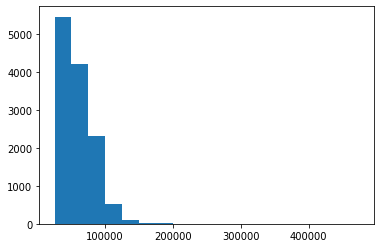

In [8]:
# create custom bins
bins = np.linspace(0, 500000, 20)[1:]

non_dp_hist, dummy = np.histogram(df['ANNUAL_RT'].tolist(), bins = bins)

plt.hist(bins[:-1], len(non_dp_hist), weights = non_dp_hist)

Let's now plot the differential private histogram regarding the same data.

(array([5.398e+03, 4.160e+03, 2.290e+03, 5.090e+02, 9.100e+01, 2.800e+01,
        1.300e+01, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([ 26315.78947368,  51169.59064327,  76023.39181287, 100877.19298246,
        125730.99415205, 150584.79532164, 175438.59649123, 200292.39766082,
        225146.19883041, 250000.        , 274853.80116959, 299707.60233918,
        324561.40350877, 349415.20467836, 374269.00584795, 399122.80701754,
        423976.60818713, 448830.40935673, 473684.21052632]),
 <a list of 18 Patch objects>)

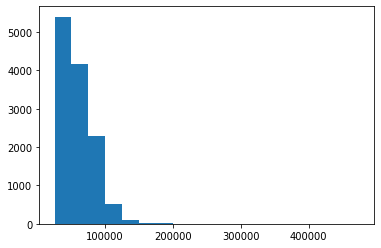

In [9]:
hist, dummy = accurate_histogram(df['ANNUAL_RT'].tolist(), bins, 1, annual_earnings_range)

plt.hist(bins[:-1], len(hist), weights = hist)

The results are more than satisfying in the naked eye. This is probably due to the large dataset size: we are not able to locate small changes. In order to do so, we are going to check our error using the accuracy error function that we have defined.

In [10]:
acc_err = accuracy_error(non_dp_hist, df['ANNUAL_RT'].tolist(), bins, 1, annual_earnings_range)

print(acc_err)

12.2


The error determines how many entries were wrongly classified in a bin (in average), when the differentially private query was run. So, eleven people out of 13.000 were wrongly classified, whereas their privacy was secured. This is quite a good trade-off!

In order to decide on the best epsilon value, we are going to apply the same technique as shown in the epsilon measurements earlier. We are going to examine the behavior of the accuracy error when we increase the epsilon value.

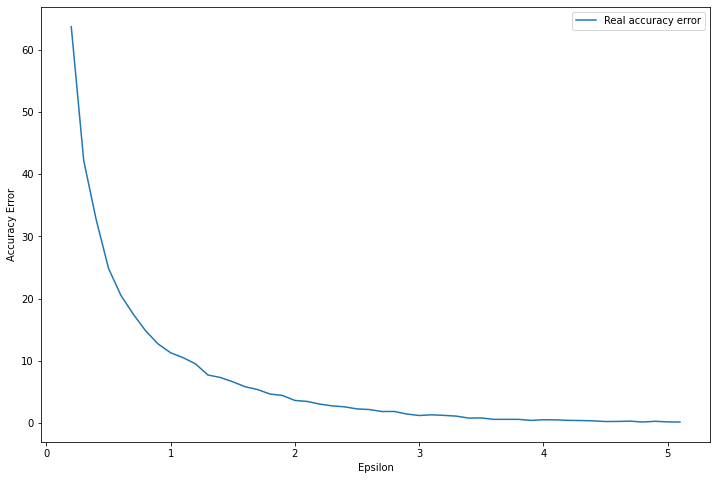

In [11]:
# epsilon values we are going to run the query with
epsilon = [i/10 + 0.2 for i in range (0,50)]
# list of the accuracy results, empty in the beggining
results = []

# loop through different epsilons
for e in epsilon:
    res = accuracy_error(non_dp_hist, df['ANNUAL_RT'].tolist(), bins, e, annual_earnings_range)
    results.append(res)

# plot the result 
plt.figure(figsize = (12,8))

plt.plot(epsilon, results, label='Real accuracy error')

plt.legend(loc='best')

plt.xlabel('Epsilon')
plt.ylabel('Accuracy Error')
plt.show()

We observe that the curve is rather normal according to both the theory and our previous experience: The biggest the epsilon gets, the smallest the accuracy error (but the higher the privacy loss).

Even for very small epsilon values ($\leq 1$), we observe that there are less than 100 out of 13.000 people wrongly classified in a bin.

Of course, if we increase the bins(and thus the precision of the classification needed, the error will increase).

### Histogram on gross earnings

Last but not least, let's apply the same techniques in order to plot a differentially private histogram for the gross earnings of the employers. We are not going to study the accuracy results, as there will be very similar to the ones we have shown earlier.

(array([3743., 3580., 2189.,  980.,  418.,  136.,   40.,    6.,    5.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 26315.78947368,  51169.59064327,  76023.39181287, 100877.19298246,
        125730.99415205, 150584.79532164, 175438.59649123, 200292.39766082,
        225146.19883041, 250000.        , 274853.80116959, 299707.60233918,
        324561.40350877, 349415.20467836, 374269.00584795, 399122.80701754,
        423976.60818713, 448830.40935673, 473684.21052632]),
 <a list of 18 Patch objects>)

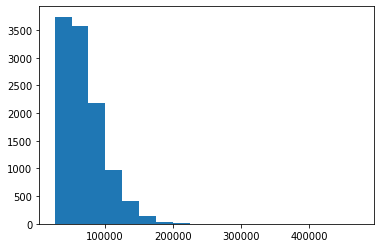

In [12]:
# create custom bins
bins = np.linspace(0, 500000, 20)[1:]

hist, dummy = accurate_histogram(df['Gross'].tolist(), bins, 1, annual_earnings_range)

plt.hist(bins[:-1], len(hist), weights = hist)

## Histogram queries in theory

Based on `Dwork, C., Roth, A. (2014). The Algorithmic Foundations of Differential Privacy` the histogram queries are very high sensitivity queries, thus a slight change to the bounds could be critical for their result. 

The writers suggest that we use noise generated by the LaPlace mechanism, but with a slight change. In detail they suggest the following:


"_In the special (but common) case in which the queries are structurally disjoint we can do much better — we do not necessarily have to let the noise scale with the number of queries. An example is the histogram query. In this type of query the universe $N^X$ is partitioned into cells, and the query asks how many database elements lie in each of the cells. Because the cells are disjoint, the addition or removal of a single database element can affect the count in exactly one cell, and the difference to that cell is bounded by 1, so histogram queries have sensitivity 1 and can be answered by adding independent draws from $Lap(\frac{1}{\epsilon})$ to the true count in each cell._"

## Conclusions

After plotting a very basic histogram using `diffprivlib`'s functions, it is clear that the histograms created can be trusted for the extraction of statistical data. They seem to be accurate with an extremely naive selection of bounds, if the query is run multiple times.